In [ ]:
'''
Marco Costante, Alex Costanzino, Alessandra Stramiglio, Xiaowei Wen
MSc students in Artificial Intelligence
@ Alma Mater Studiorum, University of Bologna
January, 2022
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Project work: **Key-Points Matching**
Key Point Analysis (KPA) is a new NLP task, with strong relations to computational argumentation, opinion analysis, and summarization.

Given an input corpus, consisting of a collection of relatively short, opinionated texts focused on a topic of interest, the goal of KPA is to produce a succinct list of the most prominent key-points in the input corpus, along with their relative prevalence. Thus, the output of KPA is a bullet-like summary, with an important quantitative angle and an associated well-defined evaluation framework. 

Successful solutions to KPA can be used to gain better insights from public opinions as expressed in social media, surveys, and so forth, giving rise to a new form of a communication channel between decision makers and people that might be impacted by the decision.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

!pip install tensorflow-text --quiet
import tensorflow_text as text

!pip install --upgrade tensorflow_hub --quiet
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from tqdm import tqdm

!pip install contractions --quiet
import contractions

!pip install focal-loss --quiet
import focal_loss

!pip install -U sentence-transformers --quiet
import sentence_transformers

## 1.0 **Data loading**
The dataset is divided in:
* Arguments (`arg_id`, `argument`, `topic`, `stance`);
* Keypoint (`key_point_id`, `keypoint`, `topic`, `stance`);
* Labels (`arg_id`, `key_point_id`, label).

Each dataset has its own split (train, dev and test).
The dataset is directly loaded via url from the GitHub repository.

In [ ]:
# Arguments dataset loading.
arguments_train = pd.read_csv(filepath_or_buffer = 'https://raw.githubusercontent.com/IBM/KPA_2021_shared_task/main/kpm_data/arguments_train.csv')
arguments_dev = pd.read_csv(filepath_or_buffer = 'https://raw.githubusercontent.com/IBM/KPA_2021_shared_task/main/kpm_data/arguments_dev.csv')
arguments_test = pd.read_csv(filepath_or_buffer = 'https://raw.githubusercontent.com/IBM/KPA_2021_shared_task/main/test_data/arguments_test.csv')

print(f'There are {len(arguments_train)} arguments in the train set, {len(arguments_dev)} arguments in the dev set and {len(arguments_test)} arguments in the test set.')

# Check.
# arguments_train.head()
# arguments_dev.head()
# arguments_test.head()

There are 5583 arguments in the train set, 932 arguments in the dev set and 723 arguments in the test set.


In [ ]:
# Key-points dataest loading.
key_points_train = pd.read_csv(filepath_or_buffer = 'https://raw.githubusercontent.com/IBM/KPA_2021_shared_task/main/kpm_data/key_points_train.csv')
key_points_dev = pd.read_csv(filepath_or_buffer = 'https://raw.githubusercontent.com/IBM/KPA_2021_shared_task/main/kpm_data/key_points_dev.csv')
key_points_test = pd.read_csv(filepath_or_buffer = 'https://raw.githubusercontent.com/IBM/KPA_2021_shared_task/main/test_data/key_points_test.csv')

print(f'There are {len(key_points_train)} keypoints in the train set, {len(key_points_dev)} keypoints in the dev set and {len(key_points_test)} keypoints in the test set.')

# Check.
# key_points_train.head()
# key_points_dev.head()
# key_points_test.head()

There are 207 keypoints in the train set, 36 keypoints in the dev set and 33 keypoints in the test set.


In [ ]:
# Labels dataset loading.
labels_train = pd.read_csv(filepath_or_buffer = 'https://raw.githubusercontent.com/IBM/KPA_2021_shared_task/main/kpm_data/labels_train.csv')
labels_dev = pd.read_csv(filepath_or_buffer = 'https://raw.githubusercontent.com/IBM/KPA_2021_shared_task/main/kpm_data/labels_dev.csv')
labels_test = pd.read_csv(filepath_or_buffer = 'https://raw.githubusercontent.com/IBM/KPA_2021_shared_task/main/test_data/labels_test.csv')

print(f'There are {len(labels_train)} labels in the train set, {len(labels_dev)} labels in the dev set and {len(labels_test)} labels in the test set.')

# Check.
# labels_train.head()
# labels_dev.head()
# labels_test.head()

There are 20635 labels in the train set, 3458 labels in the dev set and 3426 labels in the test set.


The dataset is unbalanced.

In [ ]:
# Balance of the train dataset.
print(f"There are {np.sum(labels_train['label'].tolist())} positive samples and {len(labels_train['label']) - np.sum(labels_train['label'].tolist())} negative samples over {len(labels_train['label'])} samples of the training set.")
# Balance of the dev dataset.
print(f"There are {np.sum(labels_dev['label'].tolist())} positive samples and {len(labels_dev['label']) - np.sum(labels_dev['label'].tolist())} negative samples over {len(labels_dev['label'])} samples of the development set.")
# Balance of the test dataset.
print(f"There are {np.sum(labels_test['label'].tolist())} positive samples and {len(labels_test['label']) - np.sum(labels_test['label'].tolist())} negative samples over {len(labels_test['label'])} samples of the test set.")

There are 4260 positive samples and 16375 negative samples over 20635 samples of the training set.
There are 738 positive samples and 2720 negative samples over 3458 samples of the development set.
There are 552 positive samples and 2874 negative samples over 3426 samples of the test set.


## 2.0 **Data processing**

### 2.1 **Text cleaning**
The text cleaning consists in lowercase every letter, expand abbreviations and verbal contractions, remove possible special characters and uncommon symbols.

Notice that the new dataframes override the previous ones.

In [ ]:
import re
import nltk

from typing import List, Callable
from functools import reduce

# Lowercase everything.
def lower(text: str) -> str:
    return text.lower()

# Expand abbreviations and verbal contractions.
def expand(text: str) -> str:
    return contractions.fix(text)

# Remove special characters.
def replace_special_characters(text: str) -> str:
    replace_symbols = re.compile('[/(){}\[\]\|@,;]')
    return replace_symbols.sub(' ', text)

def filter_out_uncommon_symbols(text: str) -> str:
    good_symbols = re.compile('[^0-9a-z #+_]')
    return re.sub(good_symbols, '', text)

pipeline = [lower, expand, replace_special_characters, filter_out_uncommon_symbols]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    '''
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    '''

    filter_methods = filter_methods if filter_methods is not None else pipeline

    return reduce(lambda txt, f: f(txt), filter_methods, text)

def cleaning(dataframes: list, labels: list):
  for dataframe in dataframes:
    print('Before: \n')
    print(dataframe[labels].head(5))
    
    for label in labels:
      dataframe[label] = dataframe[label].apply(lambda txt: text_prepare(txt))
    
    print('After: \n')
    print(dataframe[labels].head(5))

arguments_dataset_list = [arguments_train, arguments_dev, arguments_test]
arguments_labels_list = ['argument', 'topic']

cleaning(arguments_dataset_list, arguments_labels_list)

key_points_datasets_list = [key_points_train, key_points_dev, key_points_test]
key_points_labels_list = ['key_point', 'topic']

cleaning(key_points_datasets_list, key_points_labels_list)

Before: 

                                            argument                                          topic
0  `people reach their limit when it comes to the...  Assisted suicide should be a criminal offence
1  A patient should be able to decide when they h...  Assisted suicide should be a criminal offence
2  a person has the right to end their suffering ...  Assisted suicide should be a criminal offence
3  a person should have the dignity to choose how...  Assisted suicide should be a criminal offence
4  a person should have the right to be able to c...  Assisted suicide should be a criminal offence
After: 

                                            argument                                          topic
0  people reach their limit when it comes to thei...  assisted suicide should be a criminal offence
1  a patient should be able to decide when they h...  assisted suicide should be a criminal offence
2  a person has the right to end their suffering ...  assisted suicide should be 

In [ ]:
# Check.
# arguments_train.head()
# arguments_dev.head()
# arguments_test.head()

# key_points_train.head()
key_points_dev.head()
# key_points_test.head()

,key_point_id,key_point,topic,stance
0,kp_4_0,children can still express themselves using ot...,we should abandon the use of school uniform,-1
1,kp_4_1,school uniform reduces bullying,we should abandon the use of school uniform,-1
2,kp_4_2,school uniforms encourage discipline or focus ...,we should abandon the use of school uniform,-1
3,kp_4_3,school uniforms saves costs,we should abandon the use of school uniform,-1
4,kp_4_4,school uniforms create a sense of equality unity,we should abandon the use of school uniform,-1


### 2.2 **Text tokenization**
Text tokenization consists into split a whole sentencences into meaningful pieces of it. It is achieved with the punkt tokenizer by NLTK.

In [ ]:
# Create copies of the processed dataframes.
arguments_train_tok = arguments_train.copy()
arguments_dev_tok = arguments_dev.copy()
arguments_test_tok = arguments_test.copy()

key_points_train_tok = key_points_train.copy()
key_points_dev_tok = key_points_dev.copy()
key_points_test_tok = key_points_test.copy()

# Note: it takes a while.
from nltk.tokenize import wordpunct_tokenize

def tokenize_dataset(dataframes: list, labels: list):
  for df in dataframes:
    for lab in labels:
      df[lab] = df[lab].apply(wordpunct_tokenize)

tokenize_dataset([arguments_train_tok, arguments_dev_tok, arguments_test_tok], labels = arguments_labels_list)
tokenize_dataset([key_points_train_tok, key_points_dev_tok, key_points_test_tok], labels = key_points_labels_list)

### 2.3 **Lenghts analysis**
Padding is not needed for processor and the pre-trained models since they automatically takes into account different lengths, but is needed for the GloVe embeddings.

In any case, length distribution studies are useful to decide if it makes sense to employ attention mechanisms.

Key-points lengths are not considered since their maximum length is fixed.

The maximum found length is 44.


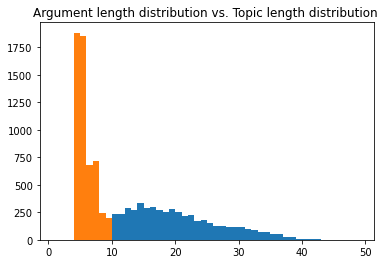

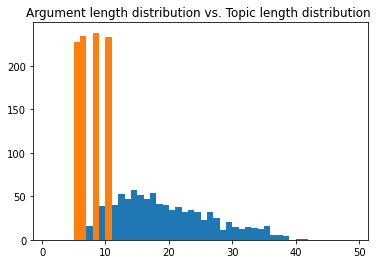

In [ ]:
def extract_info(dataframe: pd.DataFrame) -> int:
  plt.figure()
  plt.title('Argument length distribution vs. Topic length distribution ')
  
  no_token_argument = [len(sentence) for sentence in dataframe['argument']]
  n_c, _, _ = plt.hist(no_token_argument, bins = [i for i in range(1, 50)], cumulative = False)

  no_token_topic = [len(sentence) for sentence in dataframe['topic']]
  n_e, _, _ = plt.hist(no_token_topic, bins = [i for i in range(1, 50)], cumulative = False)

  return max(max(no_token_argument), max(no_token_topic))

max_tokens = max(extract_info(arguments_train_tok), extract_info(arguments_dev_tok))

print(f'The maximum found length is {max_tokens}.')

## 3.0 **The Key-Points Matching problem**
Given a controversial topic $T$ with a list of $m$ arguments and $n$ key
points:
* $A_1, A_2, \dots, A_m$; 
* $K_1, K_2, \dots, K_n$,

along with their corresponding $m+n$ stances:
* $S_1, S_2, \dots, S_{m+n}$;

with $S_i \in \{−1, 1\}$, which
imply the attack or support relationships against the topic, the task is to rank key points that have the same stance with an input argument by the matching score.

This priority is dependent on both the topic and the semantic of statements.

## 4.0 **Unsupervised approaches**

### 4.1 **Pre-trained embeddings**
It is possible to use pre-trained embeddings to measure the "distance" of each pair of keyword and argument.

GloVe is a context independent model that computes a single embedding for each word, while BERT is a contextualized embedding model that takes the entire sentence into account.

Again, we use cosine similarity to compute the match score.

For each method it is possible to decide wether to consider also topic and stance.

#### 4.1.1 **GloVe embeddings**
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.


The training objective of GloVe is to learn word vectors such that their dot product equals the logarithm of the words' probability of co-occurrence. Owing to the fact that the logarithm of a ratio equals the difference of logarithms, this objective associates (the logarithm of) ratios of co-occurrence probabilities with vector differences in the word vector space. Because these ratios can encode some form of meaning, this information gets encoded as vector differences as well. 


##### 4.1.1.1 **Out-of-vocaboulary terms & embedding**
At first some functions to handle OOVs terms and token embeddings are define. In particular:
* `build_vocaboulary`: create a double vocaboulary from a dataframe to mantain encode and decode tokens;
* `load_glove_embedding`: given a chosen embedding dimension, it downloads the corresponding pre-trained corpus;
* `get_OOV_terms`: given a vocaboulary and a word listings returns the set of OOV terms;
* `build_embedding_matrix`: returns the matrix to pass to the embedding layer as kernel initializer.

In [ ]:
import gensim
import gensim.downloader as gloader

from collections import OrderedDict
from typing import OrderedDict

def build_vocabulary(dataset: pd.DataFrame, labels: list) -> (OrderedDict[int, str], OrderedDict[str, int], list):
    idx2word = OrderedDict()
    word2idx = OrderedDict()
    
    curr_idx = 1 # Start at 1 since 0 is reserved for padding.

    for label in labels:
      for row in tqdm(dataset[label].values):
        for token in row:
            if token not in word2idx:
                word2idx[token] = curr_idx
                idx2word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx2word.values())

    return idx2word, word2idx, word_listing

def load_glove_embedding(embedding_dimension: int) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    # Sanity check.
    try:
        embedded_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding dimension.")
        raise e

    return embedded_model

def get_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: List[str]) -> list:
    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word2idx: OrderedDict[str, int],
                           vocab_size: int) -> np.ndarray:

    # Note: we take (vocab_size) + 1 since we start counting by 1, having reserved 0 for the padding.
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dimension), dtype = np.float32) 

    for word, idx in tqdm(word2idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low = -0.05, high = 0.05, size = embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

emb_dim = 300
embedded_model = load_glove_embedding(embedding_dimension = emb_dim)

[==================================================] 100.0% 376.1/376.1MB downloaded


At first the vocabularies of words and tags for the training set is created, the out-of-vocabularies (OOV) words extracted, assigning random vectors for the OOV words. The same process is repeated for the validation set, taking into account the fact that the OOV words already considered for the training set, are not OOV words for the validation set. The same was done for the test set.

Note: the process must take into account arguments and key-points (two distinct dataframes).


In [ ]:
# Step 0: load GloVe vocaboulary.
vocaboulary = list(embedded_model.vocab.keys()) 

# Step 1: creation of vocaboulary for the training set and extraction of his OOVs.
_, _, word_listing_train_arg = build_vocabulary(arguments_train_tok, ['argument'])
_, _, word_listing_train_kp = build_vocabulary(key_points_train_tok, ['key_point'])

word_listing_train = word_listing_train_arg + word_listing_train_kp

oov_terms_train = get_OOV_terms(embedded_model, word_listing_train)
print(f'There are {len(oov_terms_train)} OOVs in the training set.')

print('\n')

# Step 2: creation of vocabulary for the validation set and extraction of his OOVs, taking into account the ones already from training set.
_, _, word_listing_val_arg = build_vocabulary(arguments_dev_tok, ['argument'])
_, _, word_listing_val_kp = build_vocabulary(key_points_dev_tok, ['key_point'])

word_listing_val = word_listing_val_arg + word_listing_val_kp

oov_terms_val = get_OOV_terms(embedded_model, word_listing_val)
oov_terms_val = list(set(oov_terms_val).difference(set(oov_terms_train)))
print(f'There are {len(oov_terms_val)} new OOVs in the validation set.')

print('\n')

# Step 3: creation of vocabulary for the test set and extraction of his OOVs.
_, _, word_listing_test_arg = build_vocabulary(arguments_test_tok, ['argument'])
_, _, word_listing_test_kp = build_vocabulary(key_points_test_tok, ['key_point'])

word_listing_test = word_listing_test_arg + word_listing_test_kp

oov_terms_test = get_OOV_terms(embedded_model, word_listing_test)
oov_terms_test = list(set(oov_terms_test).difference((set(oov_terms_train).union(set(oov_terms_val)))))
print(f'There are {len(oov_terms_test)} new OOVs in the test set.')

print('\n')

# Step 4: merge vocabulary and OOVs.
vocaboulary = np.concatenate((vocaboulary, oov_terms_train, oov_terms_val, oov_terms_test))

# Step 5: creation of a comprehensive dictionary.
word2idx = dict(zip(vocaboulary, range(1, len(vocaboulary) + 1))) # Start from 1 since we reserve 0 for padding.

# Step 6: creation of the whole embedding matrix.
embedding_matrix = build_embedding_matrix(embedded_model, emb_dim, word2idx, len(word2idx))

print('\n')
print("Embedding matrix shape: {}.".format(embedding_matrix.shape))

100%|██████████| 207/207 [00:00<00:00, 401211.15it/s]


There are 235 OOVs in the training set.




100%|██████████| 36/36 [00:00<00:00, 247939.15it/s]


There are 43 new OOVs in the validation set.




100%|██████████| 33/33 [00:00<00:00, 191972.31it/s]


There are 23 new OOVs in the test set.




100%|██████████| 400301/400301 [00:01<00:00, 387886.66it/s]



Embedding matrix shape: (400302, 300).


##### 4.1.1.2 **Dataset encoding**
The datasets are encoded and aligned with the respective identifiers.

In [ ]:
def encode_sentence(sentence, word2idx):
  return [word2idx[words] for words in sentence]

def encode_dataframe(dataframe, word2idx, columns):
  encoded_dataframe = pd.DataFrame(columns = columns)

  for column in columns:
    encoded_dataframe[column] = dataframe[column].apply(lambda sentence: encode_sentence(sentence, word2idx))

  return encoded_dataframe

# The dataset is encoded and then the id columns restored.
arguments_train_enc = encode_dataframe(arguments_train_tok, word2idx, arguments_labels_list)
arguments_train_enc['arg_id'] = arguments_train['arg_id']

arguments_dev_enc = encode_dataframe(arguments_dev_tok, word2idx, arguments_labels_list)
arguments_dev_enc['arg_id'] = arguments_dev['arg_id']

arguments_test_enc = encode_dataframe(arguments_test_tok, word2idx, arguments_labels_list)
arguments_test_enc['arg_id'] = arguments_test['arg_id']

key_points_train_enc = encode_dataframe(key_points_train_tok, word2idx, key_points_labels_list)
key_points_train_enc['key_point_id'] = key_points_train['key_point_id']

key_points_dev_enc = encode_dataframe(key_points_dev_tok, word2idx, key_points_labels_list)
key_points_dev_enc['key_point_id'] = key_points_dev['key_point_id']

key_points_test_enc = encode_dataframe(key_points_test_tok, word2idx, key_points_labels_list)
key_points_test_enc['key_point_id'] = key_points_test['key_point_id']

##### 4.1.1.3 **Labels alignment**
The pairs of argument and key-point pairs identifier are extracted. With these pairs the encoded arguments and key-points are extracted.

Topic and stance gives the “main context”. The argument and the key-point can also be integrated with this main context and then matched.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def flatten(t: list) -> list:
  # Flatten a nested list.
  return [item for sublist in t for item in sublist]

indexes = [i for i in range(len(labels_test))]

# Generations of pairs arg-kp of the test set.
arg_id = [labels_test['arg_id'][k] for k in indexes]
kp_id = [labels_test['key_point_id'][k] for k in indexes]

# Arguments extraction.
arguments = flatten([arguments_test_enc.loc[arguments_test_enc['arg_id'] == arg]['argument'].tolist() for arg in arg_id])
arguments = pad_sequences(arguments, maxlen = max_tokens, padding = 'post')

# Key-points extraction.
keypoints = flatten([key_points_test_enc.loc[key_points_test_enc['key_point_id'] == kp]['key_point'].tolist() for kp in kp_id])
keypoints = pad_sequences(keypoints, maxlen = max_tokens, padding = 'post')

# Topics extraction.
topics = flatten([arguments_test_enc.loc[arguments_test_enc['arg_id'] == arg]['topic'].tolist() for arg in arg_id])
topics = pad_sequences(keypoints, maxlen = max_tokens, padding = 'post')

##### 4.1.1.4 **GloVe application**
GloVe embedding matrix is applied, unrolling the vectors in order to apply the cosine similarity.


In [ ]:
# Application of the embedding matrix.
arguments_emb = embedding_matrix[arguments].reshape((len(labels_test), -1))
keypoints_emb = embedding_matrix[keypoints].reshape((len(labels_test), -1))

# Concatenation of the topic and application of the embedding matrix.
arguments_topic = np.concatenate((arguments, topics), axis = -1)
keypoints_topic = np.concatenate((keypoints, topics), axis = -1)

arguments_topic_emb = embedding_matrix[arguments_topic].reshape((len(labels_test), -1))
keypoints_topic_emb = embedding_matrix[keypoints_topic].reshape((len(labels_test), -1))

##### 4.1.1.5 **Cosine similarity calculation and evaluation**
Cosine similarity is evaluated wether if the topic is considered or not. The general performances are worsened if the topic is taken into account, but the average precision score is higher in the latter case. 

The cause can be the redundacy in of the such feature.


In [ ]:
def cos_sim(vec1: np.ndarray, vec2: np.ndarray) -> np.ndarray:
  return np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Cosine similarity is calculated and then rounded. 
predictions_glove_no_topic = np.rint([cos_sim(arguments_emb[i], keypoints_emb[i]) for i in range(len(indexes))])
predictions_glove_with_topic = np.rint([cos_sim(arguments_topic_emb[i], keypoints_topic_emb[i]) for i in range(len(indexes))])

true_values = labels_test['label'].to_numpy()

Metrics when topic is not considered:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2874
           1       0.18      0.01      0.02       552

    accuracy                           0.83      3426
   macro avg       0.51      0.50      0.47      3426
weighted avg       0.73      0.83      0.77      3426

The average precision score is: 0.16141364461561275.
The balanced accuracy precision score is: 0.5009473994735409.
The confusion matrix is: 


Metrics when topic is considered:
              precision    recall  f1-score   support

           0       0.85      0.28      0.42      2874
           1       0.17      0.74      0.27       552

    accuracy                           0.36      3426
   macro avg       0.51      0.51      0.35      3426
weighted avg       0.74      0.36      0.40      3426

The average precision score is: 0.164798818151822.
The balanced accuracy score is: 0.5132011890714351.
The confusion matrix is: 


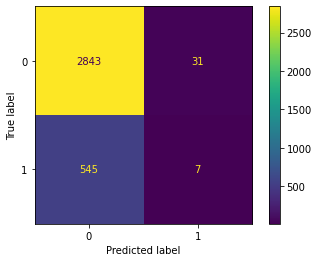

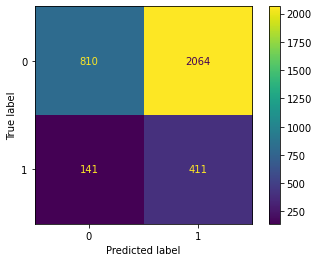

In [ ]:
from sklearn.metrics import classification_report, average_precision_score, PrecisionRecallDisplay, balanced_accuracy_score, ConfusionMatrixDisplay

print('Metrics when topic is not considered:')
print(classification_report(true_values, predictions_glove_no_topic))
print(f'The average precision score is: {average_precision_score(true_values, predictions_glove_no_topic)}.')
print(f'The balanced accuracy precision score is: {balanced_accuracy_score(true_values, predictions_glove_no_topic)}.')

print(f'The confusion matrix is: ')
ConfusionMatrixDisplay.from_predictions(y_true = true_values, y_pred = predictions_glove_no_topic);

print('\n')

print('Metrics when topic is considered:')
print(classification_report(true_values, predictions_glove_with_topic))
print(f'The average precision score is: {average_precision_score(true_values, predictions_glove_with_topic)}.')
print(f'The balanced accuracy score is: {balanced_accuracy_score(true_values, predictions_glove_with_topic)}.')

print(f'The confusion matrix is: ')
ConfusionMatrixDisplay.from_predictions(true_values, predictions_glove_with_topic);

Metrics when topic is not considered:
Metrics when topic is considered:


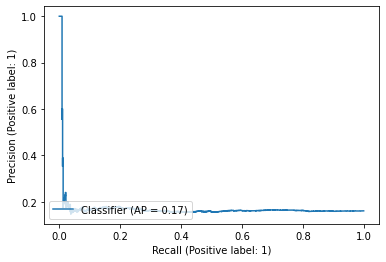

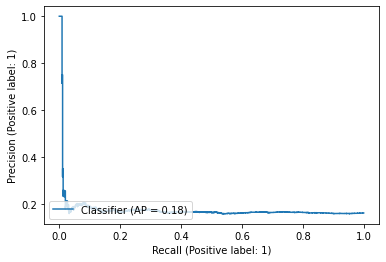

In [ ]:
print('Metrics when topic is not considered:')
PrecisionRecallDisplay.from_predictions(true_values, [cos_sim(arguments_emb[i], keypoints_emb[i]) for i in range(len(indexes))]);

print('Metrics when topic is considered:')
PrecisionRecallDisplay.from_predictions(true_values, [cos_sim(arguments_topic_emb[i], keypoints_topic_emb[i]) for i in range(len(indexes))]);

#### 4.1.2 **BERT embeddings**
BERT (Bidirectional Encoder Representations from Transformers) provides dense vector representations for natural language by using a deep, pre-trained neural network with the Transformer architecture.

BERT is a contextualized embedding model that takes the entire sentence into account. The following implementation takes automatically into account padding and encoding.

BERT provides three different kinds of output:
* `pooled_output`: pooled output of the entire sequence with shape `[batch_size, hidden_size]`. Can be used as sentence representation;
* `sequence_output`: representations of every token in the input sequence with shape `[batch_size, max_sequence_length, hidden_size]`;
* `encoder_outputs`: a list of 12 tensors of shapes `[batch_size, sequence_length, hidden_size]` with the outputs of the $i$-th Transformer block.

For sake of simplicity (and RAM occupancy) the pooled output is computed with a lighter implementation.


In [ ]:
# Faster implementation to work with pooled outputs.
pretrained_bert_model = sentence_transformers.SentenceTransformer('all-mpnet-base-v2');

In [ ]:
indexes = [i for i in range(len(labels_test))]

# Generations of pairs arg-kp of the test set.
arg_id = [labels_test['arg_id'][k] for k in indexes]
kp_id = [labels_test['key_point_id'][k] for k in indexes]

# Arguments extraction.
arguments = flatten([arguments_test.loc[arguments_test['arg_id'] == arg]['argument'].tolist() for arg in arg_id])
encoded_arguments = pretrained_bert_model.encode(arguments)

# Key-points extraction.
keypoints = flatten([key_points_test.loc[key_points_test['key_point_id'] == kp]['key_point'].tolist() for kp in kp_id])
encoded_keypoints = pretrained_bert_model.encode(keypoints)

# Topics extraction.
topics = flatten([arguments_test.loc[arguments_test['arg_id'] == arg]['topic'].tolist() for arg in arg_id])
encoded_topics = pretrained_bert_model.encode(topics)

In [ ]:
arguments_topic = np.concatenate((encoded_arguments, encoded_topics), axis = -1)
keypoints_topic = np.concatenate((encoded_keypoints, encoded_topics), axis = -1)

##### 4.1.2.1 **Cosine similarity calculation and evaluation**
Cosine similarity is evaluated wether if the topic is considered or not. The general performances are worsened if the topic is taken into account. The cause can be due to the redundacy of the such feature.


In [ ]:
def cos_sim(vec1: np.ndarray, vec2: np.ndarray) -> np.ndarray:
  return np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Cosine similarity is calculated and then rounded. 
predictions_bert_no_topic = np.rint([cos_sim(encoded_arguments[i], encoded_keypoints[i]) for i in range(len(indexes))])
predictions_bert_with_topic = np.rint([cos_sim(arguments_topic[i], keypoints_topic[i]) for i in range(len(indexes))])

true_values = labels_test['label'].to_numpy()

Metrics when topic is not considered:
              precision    recall  f1-score   support

           0       0.92      0.51      0.65      2874
           1       0.23      0.76      0.35       552

    accuracy                           0.55      3426
   macro avg       0.57      0.63      0.50      3426
weighted avg       0.81      0.55      0.60      3426

The average precision score is: 0.2125523032284284.
The balanced accuracy precision score is: 0.6341241566064566.
The confusion matrix is: 


Metrics when topic is considered:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2874
           1       0.16      1.00      0.28       552

    accuracy                           0.16      3426
   macro avg       0.58      0.50      0.14      3426
weighted avg       0.86      0.16      0.05      3426

The average precision score is: 0.16130917592051433.
The balanced accuracy score is: 0.5006958942240779.
The confusion matrix is: 


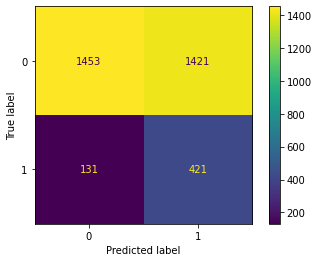

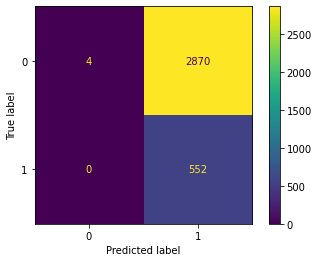

In [ ]:
from sklearn.metrics import classification_report, average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay

print('Metrics when topic is not considered:')
print(classification_report(true_values, predictions_bert_no_topic))
print(f'The average precision score is: {average_precision_score(true_values, predictions_bert_no_topic)}.')
print(f'The balanced accuracy precision score is: {balanced_accuracy_score(true_values, predictions_bert_no_topic)}.')

print(f'The confusion matrix is: ')
ConfusionMatrixDisplay.from_predictions(true_values, predictions_bert_no_topic);

print('\n')

print('Metrics when topic is considered:')
print(classification_report(true_values, predictions_bert_with_topic))
print(f'The average precision score is: {average_precision_score(true_values, predictions_bert_with_topic)}.')
print(f'The balanced accuracy score is: {balanced_accuracy_score(true_values, predictions_bert_with_topic)}.')

print(f'The confusion matrix is: ')
ConfusionMatrixDisplay.from_predictions(true_values, predictions_bert_with_topic);

Metrics when topic is not considered:
Metrics when topic is considered:


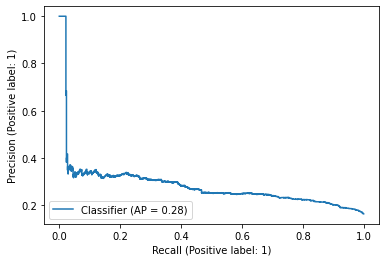

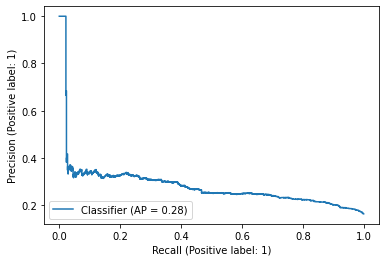

In [ ]:
print('Metrics when topic is not considered:')
PrecisionRecallDisplay.from_predictions(true_values, [cos_sim(encoded_arguments[i], encoded_keypoints[i]) for i in range(len(indexes))]);

print('Metrics when topic is considered:')
PrecisionRecallDisplay.from_predictions(true_values, [cos_sim(arguments_topic[i], keypoints_topic[i]) for i in range(len(indexes))]);

### 4.2 **Tf-idf**
In order to assess the role of lexical overlap in the matching task, we represent each argument and key point as tf-idf weighted word vectors and use their cosine similarity as the match score.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

indexes = [i for i in range(len(labels_test))]

# Generations of pairs arg-kp of the test set.
arg_id = [labels_test['arg_id'][k] for k in indexes]
kp_id = [labels_test['key_point_id'][k] for k in indexes]

# Arguments extraction.
arguments = flatten([arguments_test.loc[arguments_test['arg_id'] == arg]['argument'].tolist() for arg in arg_id])

# Key-points extraction.
keypoints = flatten([key_points_test.loc[key_points_test['key_point_id'] == kp]['key_point'].tolist() for kp in kp_id])

# Topics extraction.
topics = flatten([arguments_test.loc[arguments_test['arg_id'] == arg]['topic'].tolist() for arg in arg_id])

# Pairs of arguments and key-points extraction
args_kps = [vectorizer.fit_transform([arguments[i], keypoints[i]]).toarray() for i in indexes]
args_kps_topic = [vectorizer.fit_transform([arguments[i] + topics[i], keypoints[i] + topics[i]]).toarray() for i in indexes]

##### 4.2.2 **Cosine similarity calculation and evaluation**
Cosine similarity is evaluated wether if the topic is considered or not. The general performances are worsened if the topic is taken into account. The cause can be due to the redundacy of the such feature.


In [ ]:
predictions_tfidf = np.rint([cos_sim(args_kps[i][0], args_kps[i][1]) for i in indexes])
predictions_tfidf_topic = np.rint([cos_sim(args_kps_topic[i][0], args_kps_topic[i][1]) for i in indexes])

true_values = labels_test['label'].to_numpy()

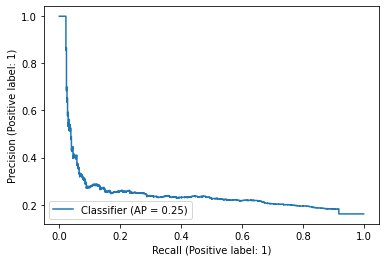

In [ ]:
PrecisionRecallDisplay.from_predictions(true_values, [cos_sim(args_kps[i][0], args_kps[i][1]) for i in indexes])
PrecisionRecallDisplay.from_predictions(true_values, [cos_sim(args_kps_topic[i][0], args_kps_topic[i][1]) for i in indexes])

Metrics when topic is not considered:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2874
           1       1.00      0.00      0.01       552

    accuracy                           0.84      3426
   macro avg       0.92      0.50      0.46      3426
weighted avg       0.87      0.84      0.77      3426

The average precision score is: 0.16416025787456534.
The accuracy precision score is: 0.5018115942028986.
The confusion matrix is: 


Metrics when topic is considered:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      2874
           1       0.17      0.26      0.20       552

    accuracy                           0.68      3426
   macro avg       0.51      0.51      0.50      3426
weighted avg       0.73      0.68      0.70      3426

The average precision score is: 0.163263762979095.
The accuracy score is: 0.5075375934162355.
The confusion matrix is: 


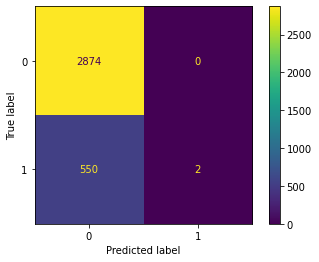

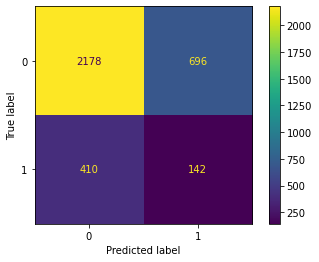

In [ ]:
from sklearn.metrics import classification_report, average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay

print('Metrics when topic is not considered:')
print(classification_report(true_values, predictions_tfidf))
print(f'The average precision score is: {average_precision_score(true_values, predictions_tfidf)}.')
print(f'The accuracy precision score is: {balanced_accuracy_score(true_values, predictions_tfidf)}.')

print(f'The confusion matrix is: ')
ConfusionMatrixDisplay.from_predictions(true_values, predictions_tfidf);

print('\n')

print('Metrics when topic is considered:')
print(classification_report(true_values, predictions_tfidf_topic))
print(f'The average precision score is: {average_precision_score(true_values, predictions_tfidf_topic)}.')
print(f'The accuracy score is: {balanced_accuracy_score(true_values, predictions_tfidf_topic)}.')

print(f'The confusion matrix is: ')
ConfusionMatrixDisplay.from_predictions(true_values, predictions_tfidf_topic);

## 5.0 **Supervised approaches**

### 5.1 **Metrics**

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

### 5.2 **Neural architecture #1**
The experimented neural architecture is composed by:
* *Stance encoder*: encode the stance value (1 or -1) employing a fully-connected network with no activation function to map the scalar input to a $N$-dimensional vector space;
* *BERT*: extract the contextualized representation for textual inputs;
* A context integration layer is done by stacking stance encoding, topic encoding and statements encoding;
* *Statement encoder*: another fully-connected network on top of the context integration layer to get the final $D$-dimensional embeddings for key points or arguments.

<div>
<center>
<img src = "https://i.ibb.co/BPGXRyJ/architecture.jpg" width = "800"/>
<center>
</div>

The extraction of contextualized vector representation is already embedded in the generator.

In [ ]:
# Load the pre-trained BERT model.
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4", trainable = False)

# Hidden states of BERT.
layers = 1024

In [ ]:
from tensorflow.keras.layers import Dense, TimeDistributed, Input, concatenate, add, average, Dropout, dot, Lambda, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant, glorot_normal
from tensorflow.keras.optimizers import RMSprop, Adamax, SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecayRestarts
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy, CosineSimilarity


# Note: the learning rate is not parametrized since we use a scheduler.
def classifier(no_last_state: int, 
               dropout: float = 0.5, recurrent_dropout: float = 0.25, 
               initial_learning_rate: float = 0.0001, N_stance: int = 16) -> Model:

  hidden_states = 32

  ''' Network structure '''
  # Inputs.
  topic_input = Input(shape = (no_last_state * layers), 
                      #batch_size = batch_size, 
                      name = 'topic_input')
  
  argument_input = Input(shape = (no_last_state * layers), 
                         #batch_size = batch_size, 
                         name = 'argument_input')
  
  keypoint_input = Input(shape = (no_last_state * layers), 
                         #batch_size = batch_size, 
                         name = 'keypoint_input')

  stance_input = Input(shape = (1, ), 
                       #batch_size = batch_size, 
                       name = 'stance_input')

  # Stance encoder.
  encoded_stance = Dense(units = N_stance, activation = None, name = 'fcn')(stance_input)
  
  # Context integration layer.
  argument_integration = concatenate([encoded_stance, topic_input, argument_input])
  keypoint_integration = concatenate([encoded_stance, topic_input, keypoint_input])

  # Statement encoder.
  mlp0 = Dense(units = (hidden_states / 2), activation = 'selu', 
              kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
              bias_regularizer = regularizers.l2(1e-4),
              activity_regularizer = regularizers.l2(1e-5),
              name = 'st_enc_0')
  
  mlp1 = Dropout(rate = dropout, name = 'st_enc_drp')

  mlp2 = Dense(units = hidden_states, activation = 'selu', 
              kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
              bias_regularizer = regularizers.l2(1e-4),
              activity_regularizer = regularizers.l2(1e-5),               
              name = 'st_enc_2')

  mlp0_argument = mlp0(argument_integration)
  mlp1_argument = mlp1(mlp0_argument)
  argument_output = mlp2(mlp1_argument)

  mlp0_keypoint = mlp0(keypoint_integration)
  mlp1_keypoint = mlp1(mlp0_keypoint)
  keypoint_output = mlp2(mlp1_keypoint)

  # Cosine similarity.
  cos_sim = dot(inputs = [argument_output, keypoint_output], axes = -1, normalize = True)
  # Rescale in range [0,1].
  output = Lambda(lambda x: (x + 1) / 2)(cos_sim)

  end_to_end = Model(inputs = (topic_input, argument_input, keypoint_input, stance_input), outputs = output)

  # Compile the model.
  scheduler_exp = ExponentialDecay(initial_learning_rate,
                                   decay_steps = 100000,
                                   decay_rate = 0.96,
                                   staircase = True)
  
  scheduler_cos = CosineDecayRestarts(initial_learning_rate,
                                      first_decay_steps = 1000)

  end_to_end.compile(loss = focal_loss.BinaryFocalLoss(gamma = 2),
                     optimizer = Adamax(learning_rate = scheduler_cos),
                     metrics = ['binary_accuracy', precision_m, recall_m, f1_m]) 
  
  # Check if the structure is correct.
  end_to_end.summary()

  return end_to_end

In [ ]:
# Number of last states to concatenate out.
l = 4

matcher = classifier(no_last_state = l, initial_learning_rate = 0.00005)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stance_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 fcn (Dense)                    (None, 16)           32          ['stance_input[0][0]']           
                                                                                                  
 topic_input (InputLayer)       [(None, 4096)]       0           []                               
                                                                                                  
 argument_input (InputLayer)    [(None, 4096)]       0           []                               
                                                                                              

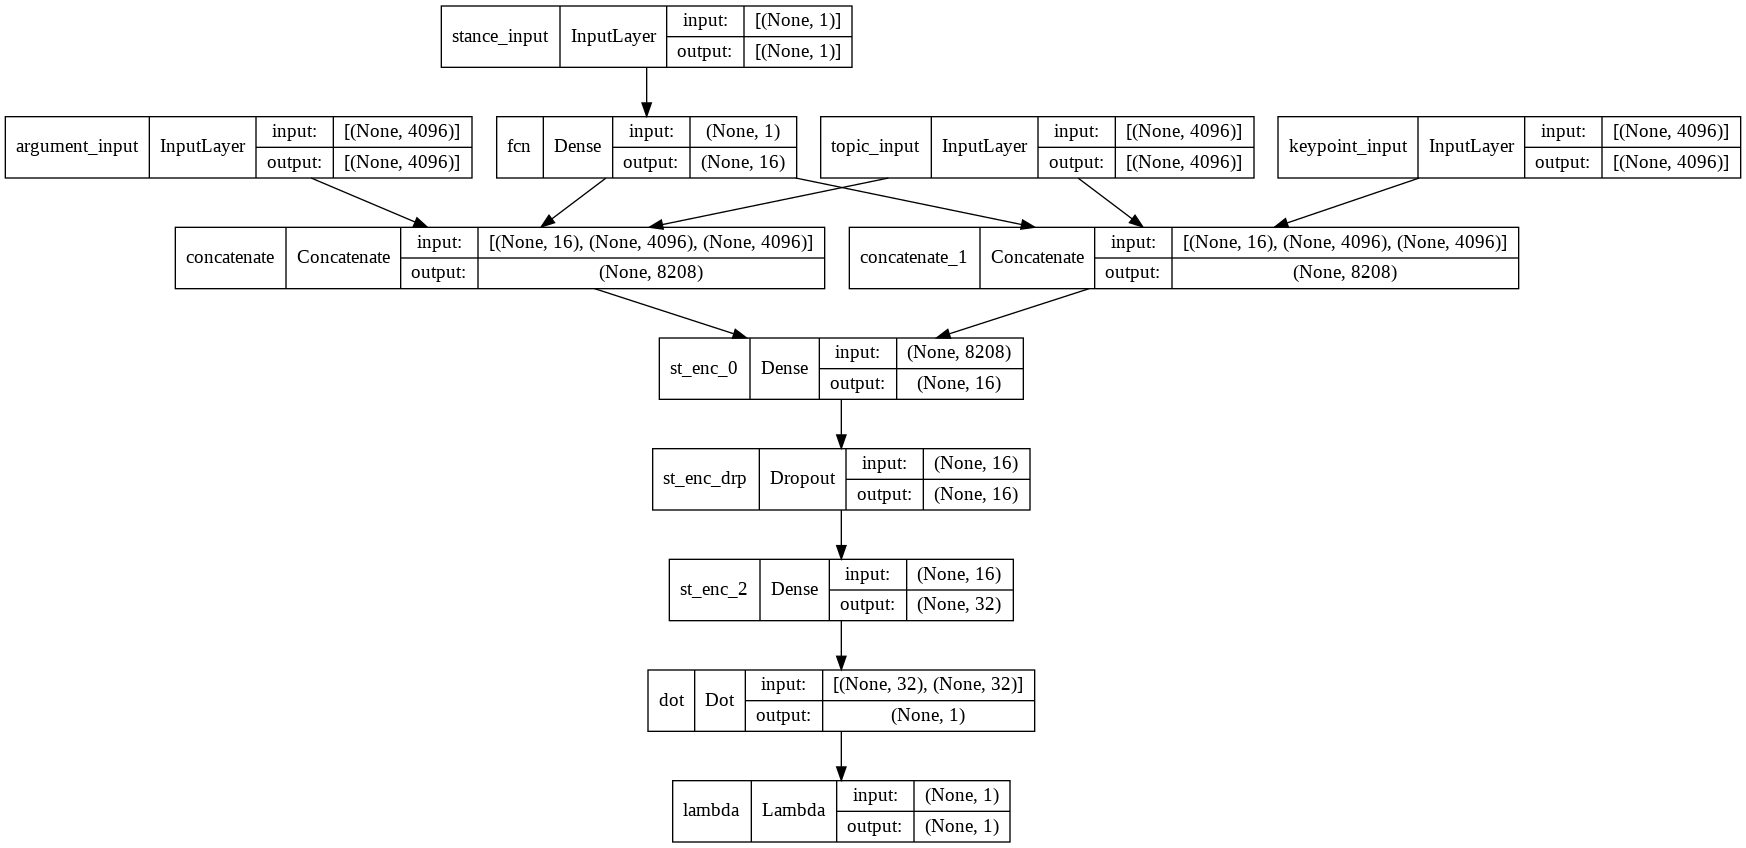

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(matcher, show_shapes = True)

#### 5.2.1 **Data generator with vector representation**
To avoid high memory usage a data generator is implemented.

The generator is initialized with:
* A *shuffle* parameter to add more robustness to the batches of data;
* A *batch_size* parameter to decide the size of the aforementioned batches;
* The dataset parameters;
* The *embedder* parameter to pass the chosen transformer;
* A *no_last_state* parameter to decide how many states of the transformer's output concatenate to obtain the representation.

The data is handled in order to parse and align the pairs in the labels dataframes. Then, topics, arguments and keypoints are encoded through BERT, and averaged over the last $l$ states.

Zero-Shot learning is a type of machine learning technique, where the model is used without fine-tuning on a particular task.

A single datapoint is output in the form of: `([topic, argument, keypoint, stance], label)`.

In [ ]:
from tensorflow.keras.utils import Sequence

def flatten(t: list) -> list:
  # Flatten a nested list.
  return [item for sublist in t for item in sublist]

class DataGenerator(Sequence):
  def __init__(self, shuffle: bool, batch_size: int, 
               arguments_df: pd.DataFrame, key_points_df: pd.DataFrame, labels_df: pd.DataFrame, 
               preprocessor, pretrained_model, no_last_state: int):
    
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.no_last_state = no_last_state
    self.preprocessor = preprocessor
    self.pretrained_model = pretrained_model

    self.arguments_df = arguments_df.copy()
    self.key_points_df = key_points_df.copy()
    self.labels_df = labels_df.copy()      
    
    # Labels.
    self.labels = labels_df['label'].values

    # Stance.
    self.stance = arguments_df['stance'].tolist()

    self.length = len(labels_df)
    self.indexes = np.arange(self.length)
    self.on_epoch_end()

    self.n = 0

  def on_epoch_end(self):
    # Shuffle the indexes to have more robust batches.
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __len__(self):
    # Length of the batch.
    return int(np.ceil(self.length / self.batch_size))

  def __getitem__(self, idx):
    '''Generate one batch of data.'''
    # Select the indexes of the batch.
    indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]

    # For each row in the labels dataframe we have the pair argument and keypoint. These two lines retrieve the pairs in the batch
    arg_id = [self.labels_df['arg_id'][k] for k in indexes]
    kp_id = [self.labels_df['key_point_id'][k] for k in indexes]

    ''' Warning: it produces nested list! '''

    # Take the topic from the arguments dataframe that match the given argument, already paired before.
    topics = flatten([self.arguments_df.loc[self.arguments_df['arg_id'] == arg]['topic'].tolist() for arg in arg_id])
    # Preprocces add [CLS] as 0 and [SEP] as 2 and pads with 1s.
    preprocessed_topic = self.preprocessor(topics)
    # Encode the topics and picks the last four states of the [CLS].
    encoded_topic = np.array(self.pretrained_model(preprocessed_topic)['encoder_outputs'][-self.no_last_state:])[:,:,0,:]
    # Swap axes to have the batch size at the beginning.
    encoded_topic = np.swapaxes(encoded_topic, 0, 1)
    encoded_topic = np.reshape(encoded_topic, (-1, self.no_last_state * layers))

    # Take the arguments from the arguments dataframe that match the given argument, already paired before.
    arguments = flatten([self.arguments_df.loc[self.arguments_df['arg_id'] == arg]['argument'].tolist() for arg in arg_id])
    # Preprocces add [CLS] as 0 and [SEP] as 2 and pads with 1s.
    preprocessed_argument = self.preprocessor(arguments)
    # Encode the arguments and picks the last four states of the [CLS].
    encoded_argument = np.array(self.pretrained_model(preprocessed_argument)['encoder_outputs'][-self.no_last_state:])[:,:,0,:]
    # Swap axes to have the batch size at the beginning.
    encoded_argument = np.swapaxes(encoded_argument, 0, 1)
    encoded_argument = np.reshape(encoded_argument, (-1, self.no_last_state * layers))
    
    # Take the keypoint from the keypoints dataframe that match the given argument, already paired before.
    keypoints = flatten([self.key_points_df.loc[self.key_points_df['key_point_id'] == kp]['key_point'].tolist() for kp in kp_id])
    # Preprocces add [CLS] as 0 and [SEP] as 2 and pads with 1s.
    preprocessed_keypoint = self.preprocessor(keypoints)
    # Encode the keypoints and picks the last four states of the [CLS].
    encoded_keypoint = np.array(self.pretrained_model(preprocessed_keypoint)['encoder_outputs'][-self.no_last_state:])[:,:,0,:]
    # Swap axes to have the batch size at the beginning.
    encoded_keypoint = np.swapaxes(encoded_keypoint, 0, 1)
    encoded_keypoint = np.reshape(encoded_keypoint, (-1, self.no_last_state * layers))

    # Take the stance from the arguments dataframe that match the given argument, already paired before.
    stance = np.array([self.arguments_df.loc[self.arguments_df['arg_id'] == arg]['stance'].tolist() for arg in arg_id])

    labels = np.array([self.labels[k] for k in indexes])

    features = [encoded_topic, 
                encoded_argument, 
                encoded_keypoint, 
                stance]

    return features, labels
    
  def __next__(self):
    if self.n >= self.__len__():
        self.n = 0
    
    result = self.__getitem__(self.n)
    self.n += 1

    return result
  

In [ ]:
# Batch size.
batch_size = 32

# Instantiate generators.
train_gen = DataGenerator(shuffle = True, batch_size = batch_size,
                          arguments_df = arguments_train, key_points_df = key_points_train, labels_df = labels_train, 
                          preprocessor = bert_preprocess_model, pretrained_model = bert_model, no_last_state = l)

dev_gen = DataGenerator(shuffle = True, batch_size = batch_size,
                        arguments_df = arguments_dev, key_points_df = key_points_dev, labels_df = labels_dev, 
                        preprocessor = bert_preprocess_model, pretrained_model = bert_model, no_last_state = l)

# No need to shuffle test data.
test_gen = DataGenerator(shuffle = False, batch_size = batch_size,
                         arguments_df = arguments_test, key_points_df = key_points_test, labels_df = labels_test, 
                         preprocessor = bert_preprocess_model, pretrained_model = bert_model, no_last_state = l)

#### 5.2.2 **Training**

In [ ]:
checkpoint = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1, mode = 'auto'),
              ModelCheckpoint(filepath = "/content/drive/MyDrive/[NLP]/project/models/adamax_cd_hu64_bs128.h5",
                              monitor = 'val_loss', verbose = 1, save_best_only = True)]

In [ ]:
# Train the model.
matcher.fit(x = train_gen,
            validation_data = dev_gen,
            epochs = 100, callbacks = checkpoint)  

In [ ]:
# Manual saving in case Colab crashes.
""" 
from tensorflow.keras.models import save_model
save_model(reloaded_model, '/content/drive/MyDrive/[NLP]/project/models/adamax_cd_hu64_bs128.h5')
"""

In [ ]:
# Reload the model and restart the training.
from tensorflow.keras.models import load_model

reloaded_model = load_model(filepath = '/content/drive/MyDrive/[NLP]/project/models/adamax_cd_hu64_bs128.h5',
                            custom_objects = {'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})

# To change optimizers in further training.
"""
scheduler_cos = CosineDecayRestarts(initial_learning_rate = 0.000001, first_decay_steps = 1000)
  
reloaded_model.compile(loss = focal_loss.BinaryFocalLoss(gamma = 2),
                       optimizer = Adamax(learning_rate = scheduler_cos),
                       metrics = ['binary_accuracy', precision_m, recall_m, f1_m]) 
"""

reloaded_model.summary()

reloaded_model.fit(x = train_gen,
                   validation_data = dev_gen,
                   epochs = 100, callbacks = checkpoint)

#### 5.2.3 **Classifier evaluation**

In [ ]:
from tensorflow.keras.models import load_model

reloaded_model = load_model(filepath = '/content/drive/MyDrive/[NLP]/project/models/adamax_cd_hu64_bs128.h5',
                            custom_objects = {'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
 
reloaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stance_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 fcn (Dense)                    (None, 16)           32          ['stance_input[0][0]']           
                                                                                                  
 topic_input (InputLayer)       [(None, 4096)]       0           []                               
                                                                                                  
 argument_input (InputLayer)    [(None, 4096)]       0           []                               
                                                                                              

In [ ]:
# Sample weighting.
total_samples = len(labels_test['label'].to_numpy())

pos_samples = sum(labels_test['label'].to_numpy())
neg_samples = total_samples - pos_samples

pos_percentage = pos_samples/total_samples
neg_percentage = neg_samples/total_samples

weights = []

for p in labels_test['label'].to_numpy():
  if p == 1:
    weights.append(pos_percentage)
  else:
    weights.append(neg_percentage)

              precision    recall  f1-score   support

         0.0       0.66      0.91      0.76      2079
         1.0       0.66      0.27      0.38      1347

    accuracy                           0.66      3426
   macro avg       0.66      0.59      0.57      3426
weighted avg       0.66      0.66      0.61      3426

The balanced accuracy score is: 0.6576143687029137.
The tuned threshold is: 0.2977856397628784.
The confusion matrix is: 


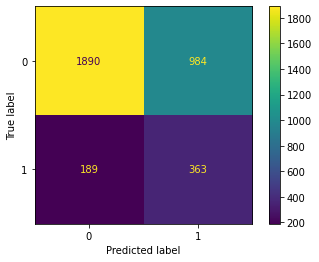

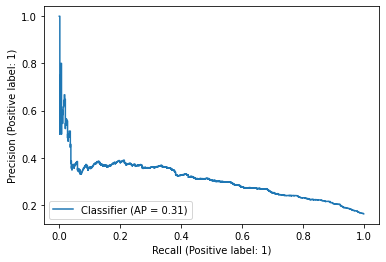

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, PrecisionRecallDisplay, roc_curve, balanced_accuracy_score, ConfusionMatrixDisplay

def evaluate_classifier(model: tf.keras.Model, test_set_generator, true_labels):
  predictions = model.predict(test_set_generator)

  # Threshold tuning.
  fpr, tpr, thresholds = roc_curve(true_labels, predictions)
  thr = thresholds[np.argmin(np.abs(fpr + tpr - 1))]

  predictions_thr = np.zeros(predictions.shape)
  predictions_thr[predictions >= thr] = 1

  print(classification_report(predictions_thr, 
                              true_labels, 
                              #sample_weight = weights
                              ))
    
  print(f'The average precision score is: {average_precision_score(true_labels, predictions_thr)}.')
  print(f'The balanced accuracy score is: {balanced_accuracy_score(true_labels, predictions_thr)}.')
  print(f'The tuned threshold is: {thr}.')

  print(f'The confusion matrix is: ')
  ConfusionMatrixDisplay.from_predictions(true_values, predictions_thr)

  PrecisionRecallDisplay.from_predictions(true_labels, predictions)
  
evaluate_classifier(reloaded_model, test_gen, labels_test['label'].to_numpy())

### 5.3 **Neural architecture #2**
The extraction of contextualized vector representation is already embedded in the generator.
Such outputs are reshaped and encoded with a fully connected layer and then the cosine similarity of the encoded vectors is computed.

<div>
<center>
<img src = "https://i.ibb.co/3hpvmNw/acrch-Tiny.jpg" width = "800"/>
<center>
</div>

The extraction of contextualized vector representation is already embedded in the generator.

In [ ]:
# Load the pre-trained BERT model.
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4", trainable = False)

# Hidden states of BERT.
layers = 1024

In [ ]:
from tensorflow.keras.layers import Dense, Reshape, Input, concatenate, add, average, Dropout, dot, Lambda, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant, glorot_normal
from tensorflow.keras.optimizers import RMSprop, Adamax, SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecayRestarts
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy, CosineSimilarity

# Note: the learning rate is not parametrized since we use a scheduler.
def classifier(no_transformers: int,
               dropout: float = 0.5, recurrent_dropout: float = 0.25, 
               initial_learning_rate: float = 0.0001) -> Model:

  hidden_states = 32

  # Inputs.
  argument_input = Input(shape = (no_transformers, layers), 
                         name = 'argument_input')
  
  keypoint_input = Input(shape = (no_transformers, layers), 
                         name = 'keypoint_input')
  
  reshaper = Reshape((-1, ))

  argument = reshaper(argument_input)
  keypoint = reshaper(keypoint_input)

  encoder = Dense(units = hidden_states, activation = 'gelu',
                  kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                  bias_regularizer = regularizers.l2(1e-4),
                  activity_regularizer = regularizers.l2(1e-5), 
                  name = 'encoder')
  
  dropout = Dropout(rate = dropout, name = 'dropout')

  argument_enc = encoder(argument)
  argument_enc = dropout(argument_enc)

  keypoint_enc = encoder(keypoint)
  keypoint_enc = dropout(keypoint_enc)

  # Cosine similarity.
  cos_sim = dot(inputs = [argument_enc, keypoint_enc], axes = -1, normalize = True)
  # Rescale in range [0,1].
  output = Lambda(lambda x: (x + 1) / 2)(cos_sim)

  end_to_end = Model(inputs = (argument_input, keypoint_input), outputs = output)

  # Compile the model.
  scheduler_exp = ExponentialDecay(initial_learning_rate,
                                   decay_steps = 100000,
                                   decay_rate = 0.96,
                                   staircase = True)
  
  scheduler_cos = CosineDecayRestarts(initial_learning_rate,
                                      first_decay_steps = 1000)

  end_to_end.compile(loss = focal_loss.BinaryFocalLoss(gamma = 2),
                     optimizer = Adamax(learning_rate = scheduler_cos),
                     metrics = ['binary_accuracy', precision_m, recall_m, f1_m]) 
  
  # Check if the structure is correct.
  end_to_end.summary()

  return end_to_end

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 argument_input (InputLayer)    [(None, 24, 1024)]   0           []                               
                                                                                                  
 keypoint_input (InputLayer)    [(None, 24, 1024)]   0           []                               
                                                                                                  
 reshape (Reshape)              (None, 24576)        0           ['argument_input[0][0]',         
                                                                  'keypoint_input[0][0]']         
                                                                                                  
 encoder (Dense)                (None, 32)           786464      ['reshape[0][0]',          

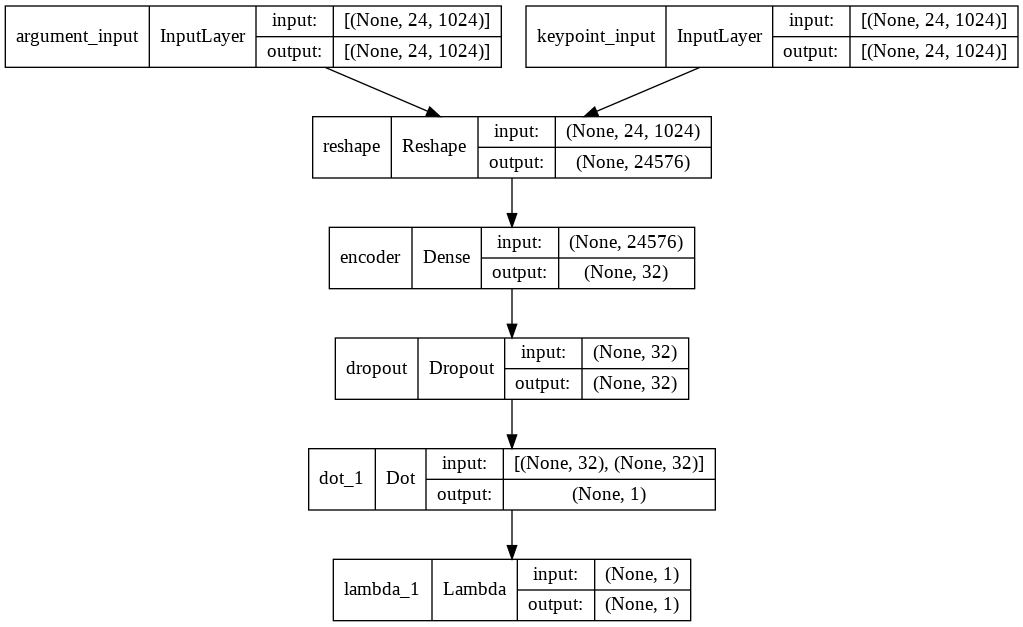

In [ ]:
matcher_two = classifier(no_transformers = 24, initial_learning_rate = 0.00005)

from tensorflow.keras.utils import plot_model
plot_model(matcher_two, show_shapes = True)

#### 5.3.1 **Data generator with vector representation**
To avoid high memory usage a data generator is implemented.

The generator is initialized with:
* A *shuffle* parameter to add more robustness to the batches of data;
* A *batch_size* parameter to decide the size of the aforementioned batches;
* The dataset parameters;
* The *embedder* parameter to pass the chosen transformer.

The data is handled in order to parse and align the pairs in the labels dataframes. Then, topics, arguments and keypoints are encoded through BERT.

Zero-Shot learning is a type of machine learning technique, where the model is used without fine-tuning on a particular task.

A single datapoint is output in the form of: `([argument, keypoint], label)`.

In [ ]:
from tensorflow.keras.utils import Sequence

def flatten(t: list) -> list:
  # Flatten a nested list.
  return [item for sublist in t for item in sublist]

class DataGeneratorReduced(Sequence):
  def __init__(self, shuffle: bool, batch_size: int, 
               arguments_df: pd.DataFrame, key_points_df: pd.DataFrame, labels_df: pd.DataFrame, 
               preprocessor, pretrained_model):
    
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.preprocessor = preprocessor
    self.pretrained_model = pretrained_model

    self.arguments_df = arguments_df.copy()
    self.key_points_df = key_points_df.copy()
    self.labels_df = labels_df.copy()      
    
    # Labels.
    self.labels = labels_df['label'].values

    # Stance.
    self.stance = arguments_df['stance'].tolist()

    self.length = len(labels_df)
    self.indexes = np.arange(self.length)
    self.on_epoch_end()

    self.n = 0

  def on_epoch_end(self):
    # Shuffle the indexes to have more robust batches.
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __len__(self):
    # Length of the batch.
    return int(np.ceil(self.length / self.batch_size))

  def __getitem__(self, idx):
    '''Generate one batch of data.'''
    # Select the indexes of the batch.
    indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]

    # For each row in the labels dataframe we have the pair argument and keypoint. These two lines retrieve the pairs in the batch
    arg_id = [self.labels_df['arg_id'][k] for k in indexes]
    kp_id = [self.labels_df['key_point_id'][k] for k in indexes]

    ''' Warning: it produces nested list! '''

    # Take the arguments from the arguments dataframe that match the given argument, already paired before.
    arguments = flatten([self.arguments_df.loc[self.arguments_df['arg_id'] == arg]['argument'].tolist() for arg in arg_id])
    # Preprocces add [CLS] as 0 and [SEP] as 2 and pads with 1s.
    preprocessed_argument = self.preprocessor(arguments)
    # Encode the arguments and picks the last four states of the [CLS].
    encoded_argument = np.array(self.pretrained_model(preprocessed_argument)['encoder_outputs'])[:,:,0,:]
    # Swap axes to have the batch size at the beginning.
    encoded_argument = np.swapaxes(encoded_argument, 0, 1)
    
    # Take the keypoint from the keypoints dataframe that match the given argument, already paired before.
    keypoints = flatten([self.key_points_df.loc[self.key_points_df['key_point_id'] == kp]['key_point'].tolist() for kp in kp_id])
    # Preprocces add [CLS] as 0 and [SEP] as 2 and pads with 1s.
    preprocessed_keypoint = self.preprocessor(keypoints)
    # Encode the keypoints and picks the last four states of the [CLS].
    encoded_keypoint = np.array(self.pretrained_model(preprocessed_keypoint)['encoder_outputs'])[:,:,0,:]
    # Swap axes to have the batch size at the beginning.
    encoded_keypoint = np.swapaxes(encoded_keypoint, 0, 1)

    labels = np.array([self.labels[k] for k in indexes])

    features = [encoded_argument, encoded_keypoint]

    return features, labels
    
  def __next__(self):
    if self.n >= self.__len__():
        self.n = 0
    
    result = self.__getitem__(self.n)
    self.n += 1

    return result
  

In [ ]:
# Batch size.
batch_size = 64

# Instantiate generators.
train_gen = DataGeneratorReduced(shuffle = True, batch_size = batch_size,
                                 arguments_df = arguments_train, key_points_df = key_points_train, labels_df = labels_train, 
                                 preprocessor = bert_preprocess_model, pretrained_model = bert_model)

dev_gen = DataGeneratorReduced(shuffle = True, batch_size = batch_size,
                               arguments_df = arguments_dev, key_points_df = key_points_dev, labels_df = labels_dev, 
                               preprocessor = bert_preprocess_model, pretrained_model = bert_model)

# No need to shuffle test data.
test_gen = DataGeneratorReduced(shuffle = False, batch_size = batch_size,
                                arguments_df = arguments_test, key_points_df = key_points_test, labels_df = labels_test, 
                                preprocessor = bert_preprocess_model, pretrained_model = bert_model)

#### 5.3.2 **Training**

In [ ]:
checkpoint = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1, mode = 'auto'),
              ModelCheckpoint(filepath = "/content/drive/MyDrive/[NLP]/project/models/adamax_cd_hu32_bs64_small.h5",
                              monitor = 'val_loss', verbose = 1, save_best_only = True)]

In [ ]:
# Train the model.
from tensorflow.keras.models import load_model

reloaded_model_two = load_model(filepath = '/content/drive/MyDrive/[NLP]/project/models/adamax_cd_hu32_bs64_small.h5',
                            custom_objects = {'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
 
reloaded_model_two.summary()

reloaded_model_two.fit(x = train_gen,
                       validation_data = dev_gen,
                       epochs = 100, callbacks = checkpoint)  

#### 5.3.3 **Classifier evaluation**

In [ ]:
from tensorflow.keras.models import load_model

reloaded_model_two = load_model(filepath = '/content/drive/MyDrive/[NLP]/project/models/adamax_cd_hu32_bs64_small.h5',
                            custom_objects = {'precision_m': precision_m, 'recall_m': recall_m, 'f1_m': f1_m})
 
reloaded_model_two.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 argument_input (InputLayer)    [(None, 24, 1024)]   0           []                               
                                                                                                  
 keypoint_input (InputLayer)    [(None, 24, 1024)]   0           []                               
                                                                                                  
 reshape (Reshape)              (None, 24576)        0           ['argument_input[0][0]',         
                                                                  'keypoint_input[0][0]']         
                                                                                                  
 encoder (Dense)                (None, 32)           786464      ['reshape[0][0]',          

              precision    recall  f1-score   support

         0.0       0.66      0.91      0.77      2093
         1.0       0.66      0.27      0.39      1333

    accuracy                           0.66      3426
   macro avg       0.66      0.59      0.58      3426
weighted avg       0.66      0.66      0.62      3426

The balanced accuracy score is: 0.6632893104595927.
The tuned threshold is: 0.3550012707710266.
The confusion matrix is: 


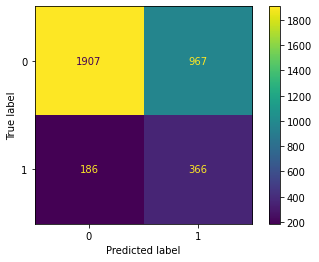

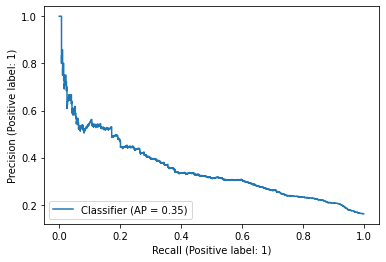

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, PrecisionRecallDisplay, roc_curve, balanced_accuracy_score, ConfusionMatrixDisplay

def evaluate_classifier(model: tf.keras.Model, test_set_generator, true_labels):
  predictions = model.predict(test_set_generator)

  # Threshold tuning.
  fpr, tpr, thresholds = roc_curve(true_labels, predictions)
  thr = thresholds[np.argmin(np.abs(fpr + tpr - 1))]

  predictions_thr = np.zeros(predictions.shape)
  predictions_thr[predictions >= thr] = 1

  print(classification_report(predictions_thr, 
                              true_labels, 
                              #sample_weight = weights
                              ))
    
  print(f'The average precision score is: {average_precision_score(true_labels, predictions_thr)}.')
  print(f'The balanced accuracy score is: {balanced_accuracy_score(true_labels, predictions_thr)}.')
  print(f'The tuned threshold is: {thr}.')


  print(f'The confusion matrix is: ')
  ConfusionMatrixDisplay.from_predictions(true_values, predictions_thr)

  PrecisionRecallDisplay.from_predictions(true_labels, predictions)
  
evaluate_classifier(reloaded_model_two, test_gen, labels_test['label'].to_numpy())